In [94]:
%matplotlib inline
from matplotlib import ticker 
littleh=0.7

In [95]:
from galsize_models.measurements import sdss_measurements
from galsize_models.measurements import load_umachine_sdss_with_meert15

full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()
sdss = full_sdss[behroozi_complete & good_profile_mask]

from scipy.stats import binned_statistic
logsm_table = np.linspace(9, 12.25, 35)
logsm_mids = 0.5*(logsm_table[:-1] + logsm_table[1:])
sdss_r50_table, __, __ = binned_statistic(sdss['sm'], sdss['r50_magr_kpc_meert15'], 
                                            bins=logsm_table, statistic='median')

sdss['median_r50'] = 10**np.interp(sdss['sm'], logsm_mids, np.log10(sdss_r50_table))
sdss['small'] = sdss['r50_magr_kpc_meert15'] < sdss['median_r50']

from slidingpercentile import python_sliding_rank
x = sdss['sm']
y = sdss['r50_magr_kpc_meert15']
window_length = 1001

sliding_rank_orders = python_sliding_rank(x, y, window_length)
size_percentile = (1. + sliding_rank_orders)/float(window_length+1)
sdss['r50_percentile'] = size_percentile

In [96]:
from galsize_models.models import load_orphan_subhalos, moustakas_sham
subhalos = load_orphan_subhalos()

subhalos['sm'] = moustakas_sham(subhalos['mpeak'], 0.25)

from galsize_models.models import orphan_selection, random_orphan_selection

mhost_dependent_orphan_mask = orphan_selection(subhalos)
mhost_dependent_orphan_mock = subhalos[mhost_dependent_orphan_mask]

# num_total_orphans = np.count_nonzero(mhost_dependent_orphan_mock['orphan'])
num_total_orphans = 300000

orphan_mask = random_orphan_selection(subhalos, num_total_orphans)
mock = subhalos[orphan_mask]

In [97]:
from galsize_models.models import component_size_vs_rhalo

normalization_all = 0.01
alpha_all = 1.
scatter_all = 0.2

mock['r50_nocorr'] = component_size_vs_rhalo(mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all)

mock['r50_maxcorr'] = component_size_vs_rhalo(mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all,
                        uran=1-mock['vmax_at_mpeak_percentile'])

mock['r50_midcorr'] = component_size_vs_rhalo(mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all,
                        uran=1-mock['noisy_vmax_at_mpeak_percentile'])


mock['r50_nospl'] = component_size_vs_rhalo(mock['rvir_zpeak_no_splashback'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all)


In [98]:
from scipy.stats import binned_statistic 

mock_r50_table, __, __ = binned_statistic(mock['sm'], mock['r50_nocorr'], bins=logsm_table, 
                                         statistic='median')
mock['median_r50'] = np.interp(mock['sm'], logsm_mids, np.log10(mock_r50_table))

mock['r50_mstar'] = 10**np.random.normal(loc=mock['median_r50'], scale=0.2)

In [99]:
np.count_nonzero(mock['r50_nocorr'] < mock['median_r50'])

20206

In [100]:
logsm_bins = np.linspace(9, 12.25, 35)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])


sdss_median_rhalf_table, __, __ = binned_statistic(sdss['sm'], 
                                      sdss['r50_magr_kpc_meert15'], 
                                     bins=logsm_bins, statistic='median')

def frac_surviving_mstar(frac_surviving_dm, a=14.2):
    return 1 - np.exp(-a*frac_surviving_dm)

def frac_r50_reduction(mstar_init, frac_surviving_mstar):
    mstar_final = frac_surviving_mstar*mstar_init
    logsm_init, logsm_final = np.log10([mstar_init, mstar_final])
    initial_r50, final_r50 = np.interp([logsm_init, logsm_final], 
                                          logsm_mids, sdss_median_rhalf_table)
    return final_r50/initial_r50

mock['frac_surviving_dm'] = mock['mvir']/mock['mpeak']
mock['frac_surviving_mstar'] = frac_surviving_mstar(mock['frac_surviving_dm'])
mock['frac_stripped_r50'] = frac_r50_reduction(10**mock['sm'], mock['frac_surviving_mstar'])
mock['r50_mstar_stripping'] = mock['r50_mstar']*mock['frac_stripped_r50']


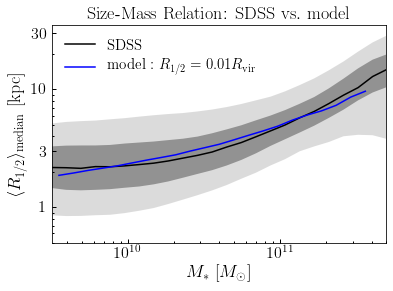

In [101]:
from scipy.special import erf, erfinv
def _percentile_from_z_score(z_score):
    return 0.5*(1 + erf(z_score/np.sqrt(2)))
low_percentile_1sigma, high_percentile_1sigma = _percentile_from_z_score(-1), _percentile_from_z_score(1)
low_percentile_3sigma, high_percentile_3sigma = _percentile_from_z_score(-3), _percentile_from_z_score(3)

logsm_table = np.linspace(9.5, 11.8, 25)
dlogsm = 0.05

r50_table_median = np.zeros_like(logsm_table)
r50_table_1sigma_low = np.zeros_like(logsm_table)
r50_table_1sigma_high = np.zeros_like(logsm_table)
r50_table_3sigma_low = np.zeros_like(logsm_table)
r50_table_3sigma_high = np.zeros_like(logsm_table)

for i, logsm in enumerate(logsm_table):
    mask = np.abs(sdss['sm'] - logsm) < dlogsm
    assert np.count_nonzero(mask) > 100, logsm
    sample_r50 = sdss['r50_magr_kpc_meert15'][mask]
    sample_r50_percentile = sdss['r50_percentile'][mask]
    
    mask_median = np.abs(sample_r50_percentile - 0.5) < 0.01
    r50_table_median[i] = np.median(sample_r50[mask_median])
    
    mask_p50 = (sample_r50_percentile > 0.25) & (sample_r50_percentile < 0.75)
    r50_table_1sigma_low[i] = np.min(sample_r50[mask_p50])
    r50_table_1sigma_high[i] = np.max(sample_r50[mask_p50])

    mask_p90 = (sample_r50_percentile > 0.05) & (sample_r50_percentile < 0.95)
    r50_table_3sigma_low[i] = np.min(sample_r50[mask_p90])
    r50_table_3sigma_high[i] = np.max(sample_r50[mask_p90])

from scipy.stats import binned_statistic
mock_r50_median, __, __ = binned_statistic(
            mock['sm'], mock['r50_nocorr'], bins=logsm_table, statistic='median')
logsm_mids = 0.5*(logsm_table[:-1] + logsm_table[1:])

fig, ax = plt.subplots(1, 1)
__=ax.loglog()

xmin, xmax = 10**9.5, 5e11
ymin, ymax = 0.5, 35
_xlabel = r'$M_{\ast}$ $[M_{\odot}]$'
_ylabel = r'$\langle R_{1/2} \rangle_{\rm median}$ $[{\rm kpc}]$'
xlim = ax.set_xlim(xmin, xmax)
ylim = ax.set_ylim(ymin, ymax)
__=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
__=ax.set_yticks((1, 3, 10, 30))

ylabel=ax.set_ylabel(_ylabel)
xlabel=ax.set_xlabel(_xlabel)
title=ax.set_title(r'${\rm Size}$-${\rm Mass\ Relation}$: ${\rm SDSS\ vs.\ model}$')

__=ax.plot(10**logsm_table, r50_table_median, color='k', label=r'${\rm SDSS}$')
__=ax.plot(10**logsm_mids[:-2], mock_r50_median[:-2], color='blue', 
           label=r'${\rm model:}\ R_{1/2}=0.01R_{\rm vir}$')

y1, y2 = r50_table_3sigma_low, r50_table_3sigma_high
from scipy.signal import savgol_filter
y1_smooth = savgol_filter(y1, 7, 3)
y2_smooth = savgol_filter(y2, 7, 3)
# __=ax.fill_between(10**logsm_table, y1, y2, facecolor='lightgray', alpha=0.8)
__=ax.fill_between(10**logsm_table, y1_smooth, y2_smooth, facecolor='lightgray', alpha=0.8)

y1, y2 = r50_table_1sigma_low, r50_table_1sigma_high
y1_smooth = savgol_filter(y1, 7, 3)
y2_smooth = savgol_filter(y2, 7, 3)
# __=ax.fill_between(10**logsm_table, y1, y2, facecolor='gray', alpha=0.8)
__=ax.fill_between(10**logsm_table, y1_smooth, y2_smooth, facecolor='gray', alpha=0.8)


leg = ax.legend()

# figname = 'rvir_only_rhalf_vs_mstar_sham_model.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [102]:
from galsize_models.measurements import single_component_clustering

In [103]:
mock['r50'] = mock['r50_nocorr']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_nocorr, wp_all_mock_sm9p75_nocorr, wp_large_mock_sm9p75_nocorr = _x[1]
wp_small_mock_sm10p25_nocorr, wp_all_mock_sm10p25_nocorr, wp_large_mock_sm10p25_nocorr = _x[2]
wp_small_mock_sm10p75_nocorr, wp_all_mock_sm10p75_nocorr, wp_large_mock_sm10p75_nocorr = _x[3]
wp_small_mock_sm11p0_nocorr, wp_all_mock_sm11p0_nocorr, wp_large_mock_sm11p0_nocorr = _x[4]
wp_small_mock_sm11p25_nocorr, wp_all_mock_sm11p25_nocorr, wp_large_mock_sm11p25_nocorr = _x[5]


In [104]:
mock['r50'] = mock['r50_midcorr']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_midcorr, wp_all_mock_sm9p75_midcorr, wp_large_mock_sm9p75_midcorr = _x[1]
wp_small_mock_sm10p25_midcorr, wp_all_mock_sm10p25_midcorr, wp_large_mock_sm10p25_midcorr = _x[2]
wp_small_mock_sm10p75_midcorr, wp_all_mock_sm10p75_midcorr, wp_large_mock_sm10p75_midcorr = _x[3]
wp_small_mock_sm11p0_midcorr, wp_all_mock_sm11p0_midcorr, wp_large_mock_sm11p0_midcorr = _x[4]
wp_small_mock_sm11p25_midcorr, wp_all_mock_sm11p25_midcorr, wp_large_mock_sm11p25_midcorr = _x[5]


In [105]:
mock['r50'] = mock['r50_mstar']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_mstar, wp_all_mock_sm9p75_mstar, wp_large_mock_sm9p75_mstar = _x[1]
wp_small_mock_sm10p25_mstar, wp_all_mock_sm10p25_mstar, wp_large_mock_sm10p25_mstar = _x[2]
wp_small_mock_sm10p75_mstar, wp_all_mock_sm10p75_mstar, wp_large_mock_sm10p75_mstar = _x[3]
wp_small_mock_sm11p0_mstar, wp_all_mock_sm11p0_mstar, wp_large_mock_sm11p0_mstar = _x[4]
wp_small_mock_sm11p25_mstar, wp_all_mock_sm11p25_mstar, wp_large_mock_sm11p25_mstar = _x[5]


In [106]:
mock['r50'] = mock['r50_nospl']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_nospl, wp_all_mock_sm9p75_nospl, wp_large_mock_sm9p75_nospl = _x[1]
wp_small_mock_sm10p25_nospl, wp_all_mock_sm10p25_nospl, wp_large_mock_sm10p25_nospl = _x[2]
wp_small_mock_sm10p75_nospl, wp_all_mock_sm10p75_nospl, wp_large_mock_sm10p75_nospl = _x[3]
wp_small_mock_sm11p0_nospl, wp_all_mock_sm11p0_nospl, wp_large_mock_sm11p0_nospl = _x[4]
wp_small_mock_sm11p25_nospl, wp_all_mock_sm11p25_nospl, wp_large_mock_sm11p25_nospl = _x[5]


In [107]:
mock['r50'] = mock['r50_nocorr']

median_rhalf_mock, __, __ = binned_statistic(mock['sm'][~mock['orphan']], 
                        mock['r50'][~mock['orphan']], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock[~mock['orphan']])
rp_mids = _x[0]
wp_small_mock_sm9p75_noorphan, wp_all_mock_sm9p75_noorphan, wp_large_mock_sm9p75_noorphan = _x[1]
wp_small_mock_sm10p25_noorphan, wp_all_mock_sm10p25_noorphan, wp_large_mock_sm10p25_noorphan = _x[2]
wp_small_mock_sm10p75_noorphan, wp_all_mock_sm10p75_noorphan, wp_large_mock_sm10p75_noorphan = _x[3]
wp_small_mock_sm11p0_noorphan, wp_all_mock_sm11p0_noorphan, wp_large_mock_sm11p0_noorphan = _x[4]
wp_small_mock_sm11p25_noorphan, wp_all_mock_sm11p25_noorphan, wp_large_mock_sm11p25_noorphan = _x[5]


In [108]:
# from galsize_models.models import random_orphan_selection

# num_orphans = np.count_nonzero(mock['orphan'])
# random_orphan_mask = random_orphan_selection(subhalos, num_orphans)
# mock_random_orphans = subhalos[random_orphan_mask]

normalization_all = 0.01
alpha_all = 1.
scatter_all = 0.2

mhost_dependent_orphan_mock['r50_nocorr'] = component_size_vs_rhalo(
        mhost_dependent_orphan_mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all)

mhost_dependent_orphan_mock['r50'] = mhost_dependent_orphan_mock['r50_nocorr']
median_rhalf_mock_mhost_orphans, __, __ = binned_statistic(
        mhost_dependent_orphan_mock['sm'], mhost_dependent_orphan_mock['r50'], 
        bins=logsm_table, statistic='median')

mhost_dependent_orphan_mock['r50_median'] = np.interp(
        mhost_dependent_orphan_mock['sm'], logsm_mids, median_rhalf_mock_mhost_orphans)

_x = single_component_clustering(mhost_dependent_orphan_mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_mhost_orphans, wp_all_mock_sm9p75_mhost_orphans, wp_large_mock_sm9p75_mhost_orphans = _x[1]
wp_small_mock_sm10p25_mhost_orphans, wp_all_mock_sm10p25_mhost_orphans, wp_large_mock_sm10p25_mhost_orphans = _x[2]
wp_small_mock_sm10p75_mhost_orphans, wp_all_mock_sm10p75_mhost_orphans, wp_large_mock_sm10p75_mhost_orphans = _x[3]
wp_small_mock_sm11p0_mhost_orphans, wp_all_mock_sm11p0_mhost_orphans, wp_large_mock_sm11p0_mhost_orphans = _x[4]
wp_small_mock_sm11p25_mhost_orphans, wp_all_mock_sm11p25_mhost_orphans, wp_large_mock_sm11p25_mhost_orphans = _x[5]

In [109]:
mock['r50'] = mock['r50_mstar_stripping']

median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table, 
                                            statistic='median')

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_mstar_stripping, wp_all_mock_sm9p75_mstar_stripping, wp_large_mock_sm9p75_mstar_stripping = _x[1]
wp_small_mock_sm10p25_mstar_stripping, wp_all_mock_sm10p25_mstar_stripping, wp_large_mock_sm10p25_mstar_stripping = _x[2]
wp_small_mock_sm10p75_mstar_stripping, wp_all_mock_sm10p75_mstar_stripping, wp_large_mock_sm10p75_mstar_stripping = _x[3]
wp_small_mock_sm11p0_mstar_stripping, wp_all_mock_sm11p0_mstar_stripping, wp_large_mock_sm11p0_mstar_stripping = _x[4]
wp_small_mock_sm11p25_mstar_stripping, wp_all_mock_sm11p25_mstar_stripping, wp_large_mock_sm11p25_mstar_stripping = _x[5]


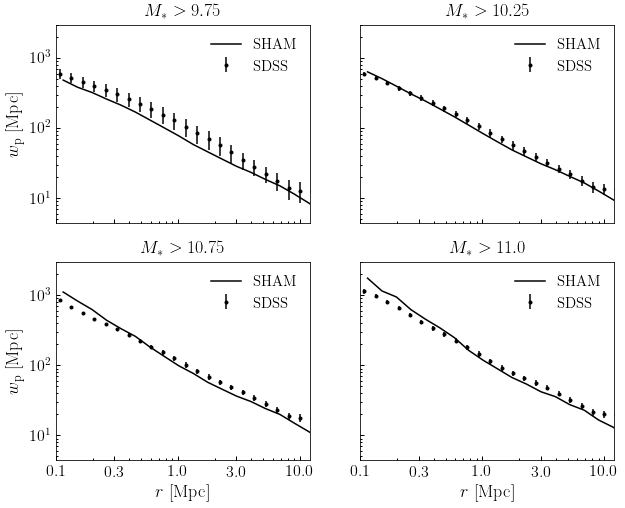

In [110]:
from galsize_models.measurements import sdss_measurements
littleh = 0.7
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    __=ax.loglog()
    xlim = ax.set_xlim(0.1, 12)

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='k', label=r'${\rm SDSS}$')


ifirst=0
__=ax1.plot(rp_mids, wp_all_mock_sm9p75_nocorr, color='k', label=r'${\rm SHAM}$')
__=ax2.plot(rp_mids, wp_all_mock_sm10p25_nocorr, color='k', label=r'${\rm SHAM}$')
__=ax3.plot(rp_mids, wp_all_mock_sm10p75_nocorr, color='k', label=r'${\rm SHAM}$')
__=ax4.plot(rp_mids[ifirst:], wp_all_mock_sm11p0_nocorr[ifirst:], color='k', label=r'${\rm SHAM}$')

__=ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())

__=ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax3.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax4.set_xticks((0.1, 0.3, 1, 3, 10))

for ax in (ax1, ax2, ax3, ax4):
    __=ax.legend()
    
# figname = 'baseline_sham.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


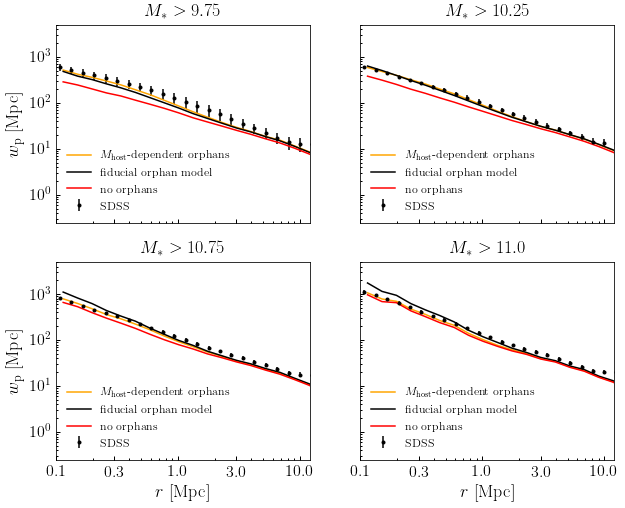

In [111]:
from galsize_models.measurements import sdss_measurements
littleh = 0.7
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    __=ax.loglog()
    xlim = ax.set_xlim(0.1, 12)
    ylim = ax.set_ylim(0.25, 5e3)

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='k', label=r'${\rm SDSS}$')


ifirst=0
__=ax1.plot(rp_mids, wp_all_mock_sm9p75_mhost_orphans, 
            color='orange', label=r'$M_{\rm host}$-${\rm dependent\ orphans}$')
__=ax2.plot(rp_mids, wp_all_mock_sm10p25_mhost_orphans, 
            color='orange', label=r'$M_{\rm host}$-${\rm dependent\ orphans}$')
__=ax3.plot(rp_mids, wp_all_mock_sm10p75_mhost_orphans, 
            color='orange', label=r'$M_{\rm host}$-${\rm dependent\ orphans}$')
__=ax4.plot(rp_mids, wp_all_mock_sm11p0_mhost_orphans, 
            color='orange', label=r'$M_{\rm host}$-${\rm dependent\ orphans}$')

__=ax1.plot(rp_mids, wp_all_mock_sm9p75_nocorr, 
            color='k', label=r'${\rm fiducial\ orphan\ model}$')
__=ax2.plot(rp_mids, wp_all_mock_sm10p25_nocorr, 
            color='k', label=r'${\rm fiducial\ orphan\ model}$')
__=ax3.plot(rp_mids, wp_all_mock_sm10p75_nocorr, 
            color='k', label=r'${\rm fiducial\ orphan\ model}$')
__=ax4.plot(rp_mids, wp_all_mock_sm11p0_nocorr, 
            color='k', label=r'${\rm fiducial\ orphan\ model}$')

__=ax1.plot(rp_mids, wp_all_mock_sm9p75_noorphan, color='red', label=r'${\rm no\ orphans}$')
__=ax2.plot(rp_mids, wp_all_mock_sm10p25_noorphan, color='red', label=r'${\rm no\ orphans}$')
__=ax3.plot(rp_mids, wp_all_mock_sm10p75_noorphan, color='red', label=r'${\rm no\ orphans}$')
__=ax4.plot(rp_mids, wp_all_mock_sm11p0_noorphan, color='red', label=r'${\rm no\ orphans}$')

__=ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())

__=ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax3.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax4.set_xticks((0.1, 0.3, 1, 3, 10))

for ax in (ax1, ax2, ax3, ax4):
    __=ax.legend(fontsize=12)
    
# figname = 'baseline_sham_orphans.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


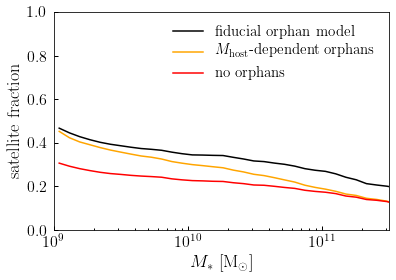

In [112]:
from scipy.stats import binned_statistic
logsm_bins_fsat = np.linspace(9, 11.6, 35)
logsm_mids_fsat = 0.5*(logsm_bins_fsat[:-1] + logsm_bins_fsat[1:])
mean_fsat_fiducial, __, __ = binned_statistic(mock['sm'], mock['upid']!=-1, 
                                              bins=logsm_bins_fsat)

mask = ~mock['orphan']
mean_fsat_noorphan, __, __ = binned_statistic(mock['sm'][mask], mock['upid'][mask]!=-1, 
                                              bins=logsm_bins_fsat)

mean_fsat_mhost_orphan, __, __ = binned_statistic(mhost_dependent_orphan_mock['sm'], 
                                                   mhost_dependent_orphan_mock['upid']!=-1, 
                                              bins=logsm_bins_fsat)

from scipy.signal import savgol_filter
mean_fsat_fiducial_smooth = savgol_filter(mean_fsat_fiducial, 7, 3)
mean_fsat_noorphan_smooth = savgol_filter(mean_fsat_noorphan, 7, 3)
mean_fsat_mhost_orphan_smooth = savgol_filter(mean_fsat_mhost_orphan, 7, 3)

fig, ax = plt.subplots(1, 1)

xscale = ax.set_xscale('log')
xlim = ax.set_xlim(10**9., 10**11.5)
ylim = ax.set_ylim(0, 1)
__=ax.plot(10**logsm_mids_fsat, mean_fsat_fiducial_smooth, 
           color='k', label=r'${\rm fiducial\ orphan\ model}$')
__=ax.plot(10**logsm_mids_fsat, mean_fsat_mhost_orphan_smooth, 
           color='orange', label=r'$M_{\rm host}$-${\rm dependent\ orphans}$')
__=ax.plot(10**logsm_mids_fsat, mean_fsat_noorphan_smooth, 
           color='red', label=r'${\rm no\ orphans}$')

__=ax.legend()
__=ax.tick_params(pad=7)

xlabel = ax.set_xlabel(r'$M_{\ast}$  $[{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'${\rm satellite\ fraction}$')

# figname = 'orphan_satellite_fraction.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


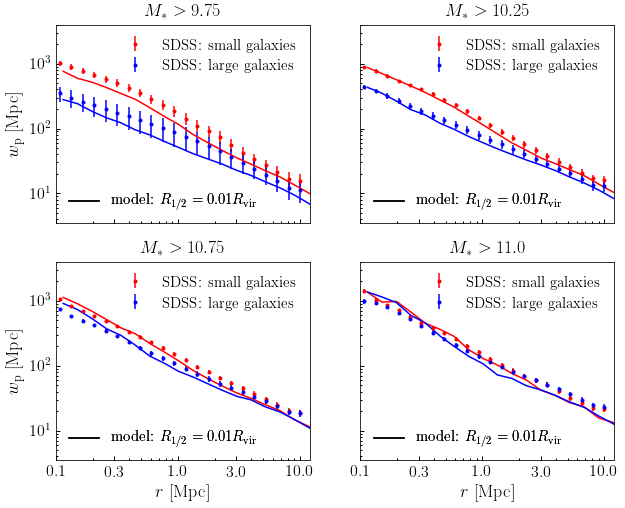

In [113]:
from galsize_models.measurements import sdss_measurements
littleh = 0.7
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    __=ax.loglog()
    xlim = ax.set_xlim(0.1, 12)

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')


small_sdss_label = r'${\rm SDSS}$: ${\rm small\ galaxies}$'
large_sdss_label = r'${\rm SDSS}$: ${\rm large\ galaxies}$'
ifirst=0
x = sdss_measurements.rp*littleh
sdss_small1=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75_small*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='red', label=small_sdss_label)
sdss_small2=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25_small*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='red')
sdss_small3=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75_small*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='red', label=small_sdss_label)
sdss_small4=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0_small[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='red')

sdss_large1=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75_large*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='blue', label=large_sdss_label)
sdss_large2=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25_large*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='blue')
sdss_large3=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75_large*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='blue', label=large_sdss_label)
sdss_large4=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0_large[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='blue')

model_label = r'${\rm model}$: $R_{1/2}=0.01R_{\rm vir}$'
ifirst=0
model_small1=ax1.plot(rp_mids, wp_small_mock_sm9p75_nocorr, color='red')
model_small2=ax2.plot(rp_mids, wp_small_mock_sm10p25_nocorr, color='red', 
            label=model_label)
model_small3=ax3.plot(rp_mids, wp_small_mock_sm10p75_nocorr, color='red')
model_small4=ax4.plot(rp_mids[ifirst:], wp_small_mock_sm11p0_nocorr[ifirst:], color='red', 
            label=model_label)

model_large1=ax1.plot(rp_mids, wp_large_mock_sm9p75_nocorr, color='blue')
model_large2=ax2.plot(rp_mids, wp_large_mock_sm10p25_nocorr, color='blue')
model_large3=ax3.plot(rp_mids, wp_large_mock_sm10p75_nocorr, color='blue')
model_large4=ax4.plot(rp_mids[ifirst:], wp_large_mock_sm11p0_nocorr[ifirst:], color='blue')

__=ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())

__=ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax3.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax4.set_xticks((0.1, 0.3, 1, 3, 10))

leg1a = ax1.legend([sdss_small1, sdss_large1], 
                 [small_sdss_label, large_sdss_label], 
                 loc='upper right')
ax1.add_artist(leg1a)
leg1b = ax1.legend(model_small1, [model_label], loc='lower left')
leg1b.legendHandles[0].set_color('k')
ax1.add_artist(leg1b)

leg2a = ax2.legend([sdss_small2, sdss_large2], 
                 [small_sdss_label, large_sdss_label], 
                 loc='upper right')
ax2.add_artist(leg2a)
leg2b = ax2.legend(model_small2, [model_label], loc='lower left')
leg2b.legendHandles[0].set_color('k')
ax2.add_artist(leg2b)

leg3a = ax3.legend([sdss_small3, sdss_large3], 
                 [small_sdss_label, large_sdss_label], 
                 loc='upper right')
ax3.add_artist(leg3a)
leg3b = ax3.legend(model_small3, [model_label], loc='lower left')
leg3b.legendHandles[0].set_color('k')
ax3.add_artist(leg3b)

leg4a = ax4.legend([sdss_small4, sdss_large4], 
                 [small_sdss_label, large_sdss_label], 
                 loc='upper right')
ax4.add_artist(leg4a)
leg4b = ax4.legend(model_small4, [model_label], loc='lower left')
leg4b.legendHandles[0].set_color('k')
ax4.add_artist(leg4b)

# leg1 = ax1.legend()
# leg2 = ax2.legend()
# leg3 = ax3.legend()
# leg4 = ax4.legend()
# leg2.legendHandles[0].set_color('k')
# leg4.legendHandles[0].set_color('k')

# figname = 'rvir_only_wp_large_small_absolute.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


In [114]:
fracdiff_sm9p75_midcorr = (wp_large_mock_sm9p75_midcorr-wp_small_mock_sm9p75_midcorr)/wp_all_mock_sm9p75_midcorr
fracdiff_sm10p25_midcorr = (wp_large_mock_sm10p25_midcorr-wp_small_mock_sm10p25_midcorr)/wp_all_mock_sm10p25_midcorr
fracdiff_sm10p75_midcorr = (wp_large_mock_sm10p75_midcorr-wp_small_mock_sm10p75_midcorr)/wp_all_mock_sm10p75_midcorr
fracdiff_sm11p0_midcorr = (wp_large_mock_sm11p0_midcorr-wp_small_mock_sm11p0_midcorr)/wp_all_mock_sm11p0_midcorr
fracdiff_sm11p25_midcorr = (wp_large_mock_sm11p25_midcorr-wp_small_mock_sm11p25_midcorr)/wp_all_mock_sm11p25_midcorr

In [115]:
fracdiff_sm9p75_nocorr = (wp_large_mock_sm9p75_nocorr-wp_small_mock_sm9p75_nocorr)/wp_all_mock_sm9p75_nocorr
fracdiff_sm10p25_nocorr = (wp_large_mock_sm10p25_nocorr-wp_small_mock_sm10p25_nocorr)/wp_all_mock_sm10p25_nocorr
fracdiff_sm10p75_nocorr = (wp_large_mock_sm10p75_nocorr-wp_small_mock_sm10p75_nocorr)/wp_all_mock_sm10p75_nocorr
fracdiff_sm11p0_nocorr = (wp_large_mock_sm11p0_nocorr-wp_small_mock_sm11p0_nocorr)/wp_all_mock_sm11p0_nocorr
fracdiff_sm11p25_nocorr = (wp_large_mock_sm11p25_nocorr-wp_small_mock_sm11p25_nocorr)/wp_all_mock_sm11p25_nocorr

In [116]:
fracdiff_sm9p75_mstar = (wp_large_mock_sm9p75_mstar-wp_small_mock_sm9p75_mstar)/wp_all_mock_sm9p75_mstar
fracdiff_sm10p25_mstar = (wp_large_mock_sm10p25_mstar-wp_small_mock_sm10p25_mstar)/wp_all_mock_sm10p25_mstar
fracdiff_sm10p75_mstar = (wp_large_mock_sm10p75_mstar-wp_small_mock_sm10p75_mstar)/wp_all_mock_sm10p75_mstar
fracdiff_sm11p0_mstar = (wp_large_mock_sm11p0_mstar-wp_small_mock_sm11p0_mstar)/wp_all_mock_sm11p0_mstar
fracdiff_sm11p25_mstar = (wp_large_mock_sm11p25_mstar-wp_small_mock_sm11p25_mstar)/wp_all_mock_sm11p25_mstar

In [117]:
fracdiff_sm9p75_nospl = (wp_large_mock_sm9p75_nospl-wp_small_mock_sm9p75_nospl)/wp_all_mock_sm9p75_nospl
fracdiff_sm10p25_nospl = (wp_large_mock_sm10p25_nospl-wp_small_mock_sm10p25_nospl)/wp_all_mock_sm10p25_nospl
fracdiff_sm10p75_nospl = (wp_large_mock_sm10p75_nospl-wp_small_mock_sm10p75_nospl)/wp_all_mock_sm10p75_nospl
fracdiff_sm11p0_nospl = (wp_large_mock_sm11p0_nospl-wp_small_mock_sm11p0_nospl)/wp_all_mock_sm11p0_nospl
fracdiff_sm11p25_nospl = (wp_large_mock_sm11p25_nospl-wp_small_mock_sm11p25_nospl)/wp_all_mock_sm11p25_nospl

In [118]:
fracdiff_sm9p75_noorphan = (wp_large_mock_sm9p75_noorphan-wp_small_mock_sm9p75_noorphan)/wp_all_mock_sm9p75_noorphan
fracdiff_sm10p25_noorphan = (wp_large_mock_sm10p25_noorphan-wp_small_mock_sm10p25_noorphan)/wp_all_mock_sm10p25_noorphan
fracdiff_sm10p75_noorphan = (wp_large_mock_sm10p75_noorphan-wp_small_mock_sm10p75_noorphan)/wp_all_mock_sm10p75_noorphan
fracdiff_sm11p0_noorphan = (wp_large_mock_sm11p0_noorphan-wp_small_mock_sm11p0_noorphan)/wp_all_mock_sm11p0_noorphan
fracdiff_sm11p25_noorphan = (wp_large_mock_sm11p25_noorphan-wp_small_mock_sm11p25_noorphan)/wp_all_mock_sm11p25_noorphan

In [119]:
fracdiff_sm9p75_mstar_stripping = (wp_large_mock_sm9p75_mstar_stripping-wp_small_mock_sm9p75_mstar_stripping)/wp_all_mock_sm9p75_mstar_stripping
fracdiff_sm10p25_mstar_stripping = (wp_large_mock_sm10p25_mstar_stripping-wp_small_mock_sm10p25_mstar_stripping)/wp_all_mock_sm10p25_mstar_stripping
fracdiff_sm10p75_mstar_stripping = (wp_large_mock_sm10p75_mstar_stripping-wp_small_mock_sm10p75_mstar_stripping)/wp_all_mock_sm10p75_mstar_stripping
fracdiff_sm11p0_mstar_stripping = (wp_large_mock_sm11p0_mstar_stripping-wp_small_mock_sm11p0_mstar_stripping)/wp_all_mock_sm11p0_mstar_stripping
fracdiff_sm11p25_mstar_stripping = (wp_large_mock_sm11p25_mstar_stripping-wp_small_mock_sm11p25_mstar_stripping)/wp_all_mock_sm11p25_mstar_stripping

In [120]:
fracdiff_sm9p75_mhost_orphans = (wp_large_mock_sm9p75_mhost_orphans-wp_small_mock_sm9p75_mhost_orphans)/wp_all_mock_sm9p75_mhost_orphans
fracdiff_sm10p25_mhost_orphans = (wp_large_mock_sm10p25_mhost_orphans-wp_small_mock_sm10p25_mhost_orphans)/wp_all_mock_sm10p25_mhost_orphans
fracdiff_sm10p75_mhost_orphans = (wp_large_mock_sm10p75_mhost_orphans-wp_small_mock_sm10p75_mhost_orphans)/wp_all_mock_sm10p75_mhost_orphans
fracdiff_sm11p0_mhost_orphans = (wp_large_mock_sm11p0_mhost_orphans-wp_small_mock_sm11p0_mhost_orphans)/wp_all_mock_sm11p0_mhost_orphans
fracdiff_sm11p25_mhost_orphans = (wp_large_mock_sm11p25_mhost_orphans-wp_small_mock_sm11p25_mhost_orphans)/wp_all_mock_sm11p25_mhost_orphans

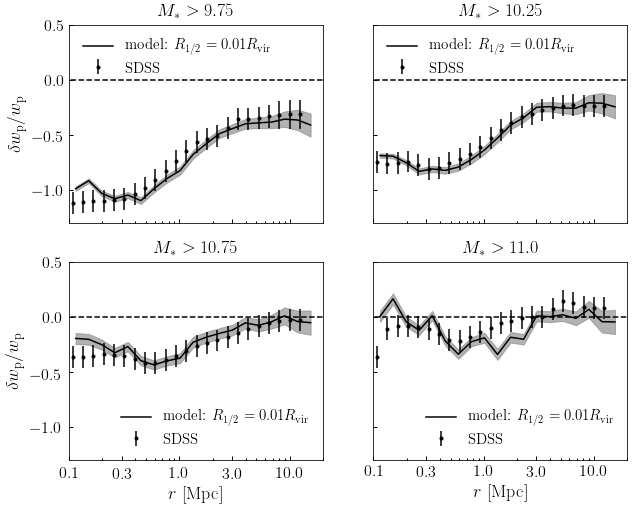

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    xscale = ax.set_xscale('log')
    xlim = ax.set_xlim(0.1, 20)
    ylim = ax.set_ylim(-1.3, 0.5)
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
ylabel3 = ax3.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

sdss_label = r'${\rm SDSS}$'
ifirst=0
x = sdss_measurements.rp*littleh
sdss1=ax1.errorbar(x, sdss_measurements.fracdiff_sm9p75_mpajhu, 
                sdss_measurements.fracdiff_sm9p75_mpajhu_err, 
               fmt='.', color='k', label=sdss_label)
sdss2=ax2.errorbar(x, sdss_measurements.fracdiff_sm10p25_mpajhu, 
                sdss_measurements.fracdiff_sm10p25_mpajhu_err, 
               fmt='.', color='k', label=sdss_label)
sdss3=ax3.errorbar(x, sdss_measurements.fracdiff_sm10p75_mpajhu, 
                sdss_measurements.fracdiff_sm10p75_mpajhu_err, 
               fmt='.', color='k', label=sdss_label)
sdss4=ax4.errorbar(x[ifirst:], sdss_measurements.fracdiff_sm11p0_mpajhu[ifirst:], 
                sdss_measurements.fracdiff_sm11p0_mpajhu_err[ifirst:], 
               fmt='.', color='k', label=sdss_label)

##########
### Load error approximation
wp_10p5 = np.load('wp_10p5.npy')
wp_11p0 = np.load('wp_11p0.npy')
wp_cov_10p5 = np.load('wp_cov_10p5.npy')
wp_cov_11p0 = np.load('wp_cov_11p0.npy')
cov_rmids = np.load('rmids.npy')

wperr_10p5 = np.array(
    [np.sqrt(wp_cov_10p5[i, i]) for i in range(wp_cov_10p5.shape[0])])
wperr_11p0 = np.array(
    [np.sqrt(wp_cov_11p0[i, i]) for i in range(wp_cov_11p0.shape[0])])

fracerr_10p5 = np.interp(rp_mids, cov_rmids, wperr_10p5/wp_10p5)
fracerr_11p0 = np.interp(rp_mids, cov_rmids, wperr_11p0/wp_11p0)
##########

ylo = fracdiff_sm9p75_nocorr - fracerr_10p5
yhi = fracdiff_sm9p75_nocorr + fracerr_10p5
__=ax1.fill_between(rp_mids, ylo, yhi, color='gray', alpha=0.6)

ylo = fracdiff_sm10p25_nocorr - fracerr_10p5
yhi = fracdiff_sm10p25_nocorr + fracerr_10p5
__=ax2.fill_between(rp_mids, ylo, yhi, color='gray', alpha=0.6)

ylo = fracdiff_sm10p75_nocorr - fracerr_11p0
yhi = fracdiff_sm10p75_nocorr + fracerr_11p0
__=ax3.fill_between(rp_mids, ylo, yhi, color='gray', alpha=0.6)

ylo = fracdiff_sm11p0_nocorr - fracerr_11p0
yhi = fracdiff_sm11p0_nocorr + fracerr_11p0
__=ax4.fill_between(rp_mids, ylo, yhi, color='gray', alpha=0.6)


model_label = r'${\rm model}$: $R_{1/2}=0.01R_{\rm vir}$'
ifirst=0
model1=ax1.plot(rp_mids, fracdiff_sm9p75_nocorr, color='k', 
           label=model_label)
model2=ax2.plot(rp_mids, fracdiff_sm10p25_nocorr, color='k', 
           label=model_label)
model3=ax3.plot(rp_mids, fracdiff_sm10p75_nocorr, color='k', 
           label=model_label)
model4=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_nocorr[ifirst:], color='k', 
           label=model_label)

ax3.set_xticks((0.1, 0.3, 1, 3, 10))
ax4.set_xticks((0.1, 0.3, 1, 3, 10))
ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

labels = [item.get_text() for item in ax2.get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax2.set_yticklabels(empty_string_labels)
ax4.set_yticklabels(empty_string_labels)
ax3.tick_params(pad=7)

from matplotlib import lines as mlines
sdss_points = mlines.Line2D([], [], c='k', marker='.', 
                           linewidth=3, label=sdss_label)

# leg4a = ax4.legend(sdss4, [sdss_label], loc='upper left')
# ax4.add_artist(leg4a)
# leg4b = ax4.legend([sdss4, model4], [sdss_label, model_label], loc='lower right')
# leg4b = ax4.legend([sdss_points, model4], [sdss_label, model_label], loc='lower right')
# leg4b = ax4.legend(model4, [model_label], loc='lower right')
# ax4.add_artist(leg4b)

legend = ax1.legend(loc='upper left')
legend = ax2.legend(loc='upper left')
legend = ax3.legend(loc='lower right')
legend = ax4.legend(loc='lower right')

figname = 'rvir_only_wp_ratios.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


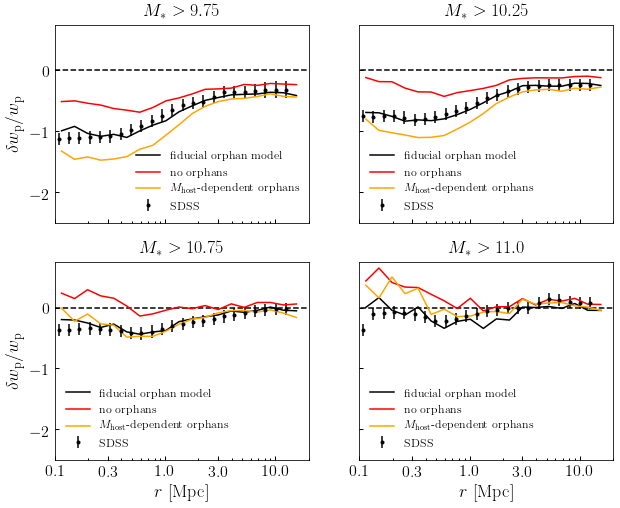

In [123]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    xscale = ax.set_xscale('log')
    xlim = ax.set_xlim(0.1, 20)
    ylim = ax.set_ylim(-2.5, 0.75)
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
ylabel3 = ax3.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, sdss_measurements.fracdiff_sm9p75_mpajhu, 
                sdss_measurements.fracdiff_sm9p75_mpajhu_err, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax2.errorbar(x, sdss_measurements.fracdiff_sm10p25_mpajhu, 
                sdss_measurements.fracdiff_sm10p25_mpajhu_err, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax3.errorbar(x, sdss_measurements.fracdiff_sm10p75_mpajhu, 
                sdss_measurements.fracdiff_sm10p75_mpajhu_err, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax4.errorbar(x[ifirst:], sdss_measurements.fracdiff_sm11p0_mpajhu[ifirst:], 
                sdss_measurements.fracdiff_sm11p0_mpajhu_err[ifirst:], 
               fmt='.', color='k', label=r'${\rm SDSS}$')

ifirst=0
__=ax1.plot(rp_mids, fracdiff_sm9p75_nocorr, color='k', 
           label=r'${\rm fiducial\ orphan\ model}$')
__=ax2.plot(rp_mids, fracdiff_sm10p25_nocorr, color='k', 
           label=r'${\rm fiducial\ orphan\ model}$')
__=ax3.plot(rp_mids, fracdiff_sm10p75_nocorr, color='k', 
           label=r'${\rm fiducial\ orphan\ model}$')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_nocorr[ifirst:], color='k', 
           label=r'${\rm fiducial\ orphan\ model}$')

__=ax1.plot(rp_mids, fracdiff_sm9p75_noorphan, color='red', 
           label=r'${\rm no\ orphans}$')
__=ax2.plot(rp_mids, fracdiff_sm10p25_noorphan, color='red', 
           label=r'${\rm no\ orphans}$')
__=ax3.plot(rp_mids, fracdiff_sm10p75_noorphan, color='red', 
           label=r'${\rm no\ orphans}$')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_noorphan[ifirst:], color='red', 
           label=r'${\rm no\ orphans}$')

__=ax1.plot(rp_mids, fracdiff_sm9p75_mhost_orphans, color='orange', 
           label=r'$M_{\rm host}$-${\rm dependent\ orphans}$')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mhost_orphans, color='orange', 
           label=r'$M_{\rm host}$-${\rm dependent\ orphans}$')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mhost_orphans, color='orange', 
           label=r'$M_{\rm host}$-${\rm dependent\ orphans}$')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_mhost_orphans[ifirst:], color='orange', 
           label=r'$M_{\rm host}$-${\rm dependent\ orphans}$')

ax3.set_xticks((0.1, 0.3, 1, 3, 10))
ax4.set_xticks((0.1, 0.3, 1, 3, 10))
ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

labels = [item.get_text() for item in ax2.get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax2.set_yticklabels(empty_string_labels)
ax4.set_yticklabels(empty_string_labels)

legend = ax1.legend(fontsize=12)
legend = ax2.legend(fontsize=12)
legend = ax3.legend(fontsize=12)
legend = ax4.legend(fontsize=12)

# figname = 'clustering_ratios_orphan_impact.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


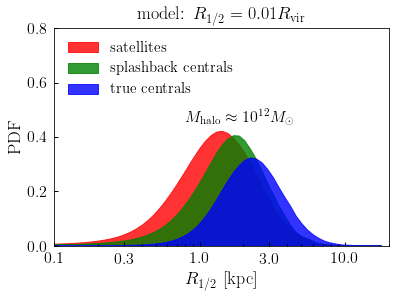

In [124]:
mask = (mock['mpeak'] > 10**11.8) & (mock['mpeak'] < 10**12.25)
sample = mock[mask]

truecen_mask = (sample['first_acc_scale'] > 1) & (sample['upid']==-1)
splcen_mask = (sample['first_acc_scale'] < 0.8) & (sample['upid']==-1)
sat_mask = sample['upid']!=-1

truecens = sample[truecen_mask]
splcens = sample[splcen_mask]
sats = sample[sat_mask]

r50_bins = np.logspace(-1.25, 1.25, 65)


fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

from scipy.stats import gaussian_kde
result_sats = gaussian_kde(sats['r50_nocorr'])
result_truecens = gaussian_kde(truecens['r50_nocorr'])
result_splcens = gaussian_kde(splcens['r50_nocorr'])

# __=ax.hist(sats['r50_nocorr'], bins=r50_bins, normed=True, 
#            alpha=0.8, color='red', label=r'satellites')
# __=ax.hist(splcens['r50_nocorr'], bins=r50_bins, normed=True, 
#            alpha=0.8, color='green', label=r'splashback centrals')
# __=ax.hist(truecens['r50_nocorr'], bins=r50_bins, normed=True, 
#            alpha=0.8, color='blue', label=r'true centrals')

__=ax.fill(r50_bins, result_sats.pdf(r50_bins),  
           alpha=0.8, color='red', label=r'${\rm satellites}$')
__=ax.fill(r50_bins, result_splcens.pdf(r50_bins), 
           alpha=0.8, color='green', label=r'${\rm splashback\ centrals}$')
__=ax.fill(r50_bins, result_truecens.pdf(r50_bins), 
           alpha=0.8, color='blue', label=r'${\rm true\ centrals}$')



ylabel = ax.set_ylabel(r'${\rm PDF}$')
xlabel = ax.set_xlabel(r'$R_{1/2}$  $[{\rm kpc}]$')

title = ax.set_title(r'${\rm model}$: $R_{1/2}=0.01R_{\rm vir}$')

xlim = ax.set_xlim(0.1, 20)
ylim = ax.set_ylim(0, .8)

ax.set_xticks((0.1, 0.3, 1, 3, 10))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.tick_params(pad=7)

legend = ax.legend(loc='upper left')

a, b = .8, 0.45
__=ax.annotate(r'$M_{\rm halo}\approx10^{12}M_{\odot}$', 
               xy=(a, b), xytext=(a, b), size=16)

# figname = 'rvir_only_cen_sat_sizes.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

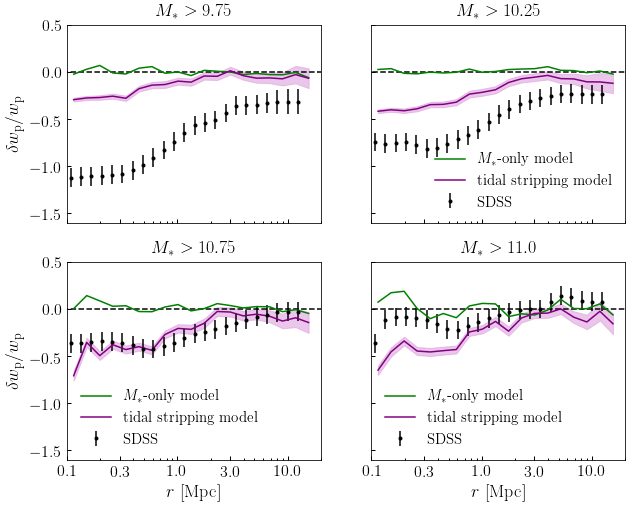

In [133]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    xscale = ax.set_xscale('log')
    xlim = ax.set_xlim(0.1, 20)
    ylim = ax.set_ylim(-1.6, 0.5)
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
ylabel3 = ax3.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, sdss_measurements.fracdiff_sm9p75_mpajhu, 
                sdss_measurements.fracdiff_sm9p75_mpajhu_err, 
               fmt='.', color='k')
__=ax2.errorbar(x, sdss_measurements.fracdiff_sm10p25_mpajhu, 
                sdss_measurements.fracdiff_sm10p25_mpajhu_err, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax3.errorbar(x, sdss_measurements.fracdiff_sm10p75_mpajhu, 
                sdss_measurements.fracdiff_sm10p75_mpajhu_err, 
               fmt='.', color='k', label=r'${\rm SDSS}$')
__=ax4.errorbar(x[ifirst:], sdss_measurements.fracdiff_sm11p0_mpajhu[ifirst:], 
                sdss_measurements.fracdiff_sm11p0_mpajhu_err[ifirst:], 
               fmt='.', color='k', label=r'${\rm SDSS}$')


ifirst=0
__=ax1.plot(rp_mids, fracdiff_sm9p75_mstar, color='green')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mstar, color='green', 
           label=r'$M_{\ast}$-${\rm only\ model}$')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mstar, color='green', 
           label=r'$M_{\ast}$-${\rm only\ model}$')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_mstar[ifirst:], color='green', 
           label=r'$M_{\ast}$-${\rm only\ model}$')

ylo = fracdiff_sm9p75_mstar_stripping - fracerr_10p5
yhi = fracdiff_sm9p75_mstar_stripping + fracerr_10p5
__=ax1.fill_between(rp_mids, ylo, yhi, color='plum', alpha=0.6)
__=ax1.plot(rp_mids, fracdiff_sm9p75_mstar_stripping, color='purple')

ylo = fracdiff_sm10p25_mstar_stripping - fracerr_10p5
yhi = fracdiff_sm10p25_mstar_stripping + fracerr_10p5
__=ax2.fill_between(rp_mids, ylo, yhi, color='plum', alpha=0.6)
__=ax2.plot(rp_mids, fracdiff_sm10p25_mstar_stripping, color='purple', 
           label=r'${\rm tidal\ stripping\ model}$')

ylo = fracdiff_sm10p75_mstar_stripping - fracerr_11p0
yhi = fracdiff_sm10p75_mstar_stripping + fracerr_11p0
__=ax3.fill_between(rp_mids, ylo, yhi, color='plum', alpha=0.6)
__=ax3.plot(rp_mids, fracdiff_sm10p75_mstar_stripping, color='purple', 
           label=r'${\rm tidal\ stripping\ model}$')

ylo = fracdiff_sm11p0_mstar_stripping - fracerr_11p0
yhi = fracdiff_sm11p0_mstar_stripping + fracerr_11p0
__=ax4.fill_between(rp_mids, ylo, yhi, color='plum', alpha=0.6)
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_mstar_stripping[ifirst:], color='purple', 
           label=r'${\rm tidal\ stripping\ model}$')

ax3.set_xticks((0.1, 0.3, 1, 3, 10))
ax4.set_xticks((0.1, 0.3, 1, 3, 10))
ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

labels = [item.get_text() for item in ax2.get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax2.set_yticklabels(empty_string_labels)
ax4.set_yticklabels(empty_string_labels)

# legend = ax1.legend()
legend = ax2.legend()
legend = ax3.legend()
legend = ax4.legend()

figname = 'alt_model_wp_ratios.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


In [134]:
from halotools.mock_observables import return_xyz_formatted_array, delta_sigma
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
particles = halocat.ptcl_table

particle_pos = return_xyz_formatted_array(particles['x'], particles['y'], particles['z'])

total_num_ptcl_in_snapshot = halocat.num_ptcl_per_dim**3
downsampling_factor = total_num_ptcl_in_snapshot/float(len(particles))
particle_masses = halocat.particle_mass

sm_mask = (mock['sm'] > 9.75) & (mock['sm']<10.25)
all_galaxy_pos = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=sm_mask)
small_sm_mask = sm_mask * ((mock['r50_nocorr'] < mock['r50_median']))
small_galaxy_pos = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=small_sm_mask)
large_sm_mask = sm_mask * ((mock['r50_nocorr'] >= mock['r50_median']))
large_galaxy_pos = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=large_sm_mask)
print(small_galaxy_pos.shape, large_galaxy_pos.shape)

((55074, 3), (55452, 3))


In [135]:
rp_bins = np.logspace(-1, 1.25, 10)
period = halocat.Lbox
rp_mids, ds_small = delta_sigma(small_galaxy_pos, particle_pos, 
                                particle_masses, downsampling_factor, 
                                  rp_bins, period)
rp_mids, ds_large = delta_sigma(large_galaxy_pos, particle_pos, 
                                particle_masses, downsampling_factor, 
                                  rp_bins, period)
ds_small = ds_small/1e12
ds_large = ds_large/1e12

In [136]:
sm_mask2 = (mock['sm'] > 10.25) & (mock['sm']<10.75)
all_galaxy_pos2 = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=sm_mask2)
small_sm_mask2 = sm_mask2 * ((mock['r50_nocorr'] < mock['r50_median']))
small_galaxy_pos2 = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=small_sm_mask2)
large_sm_mask2 = sm_mask2 * ((mock['r50_nocorr'] >= mock['r50_median']))
large_galaxy_pos2 = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=large_sm_mask2)
print(small_galaxy_pos2.shape, large_galaxy_pos2.shape)

((39870, 3), (42582, 3))


In [137]:
rp_bins = np.logspace(-1, 1.25, 10)
period = halocat.Lbox
rp_mids, ds_small2 = delta_sigma(small_galaxy_pos2, particle_pos, 
                                particle_masses, downsampling_factor, 
                                  rp_bins, period)
rp_mids, ds_large2 = delta_sigma(large_galaxy_pos2, particle_pos, 
                                particle_masses, downsampling_factor, 
                                  rp_bins, period)
ds_small2 = ds_small2/1e12
ds_large2 = ds_large2/1e12



In [138]:
sm_mask3 = (mock['sm'] > 10.75) & (mock['sm']<11.25)
all_galaxy_pos3 = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=sm_mask3)
small_sm_mask3 = sm_mask3 * ((mock['r50_nocorr'] < mock['r50_median']))
small_galaxy_pos3 = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=small_sm_mask3)
large_sm_mask3 = sm_mask3 * ((mock['r50_nocorr'] >= mock['r50_median']))
large_galaxy_pos3 = return_xyz_formatted_array(mock['x'], mock['y'], mock['z'], 
                                       velocity=mock['vz'], velocity_distortion_dimension='z',
                                       period=250, mask=large_sm_mask3)
print(small_galaxy_pos3.shape, large_galaxy_pos3.shape)

((15859, 3), (18205, 3))


In [139]:
rp_bins = np.logspace(-1, 1.25, 10)
period = halocat.Lbox
rp_mids, ds_small3 = delta_sigma(small_galaxy_pos3, particle_pos, 
                                particle_masses, downsampling_factor, 
                                  rp_bins, period)
rp_mids, ds_large3 = delta_sigma(large_galaxy_pos3, particle_pos, 
                                particle_masses, downsampling_factor, 
                                  rp_bins, period)
ds_small3 = ds_small3/1e12
ds_large3 = ds_large3/1e12


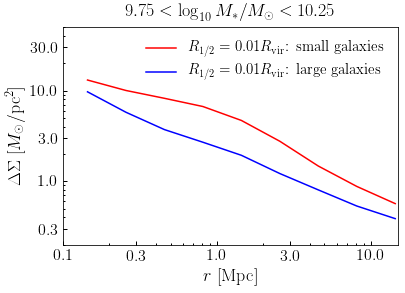

In [140]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()

__=ax.plot(rp_mids, ds_small, color='red', 
           label=r'$R_{1/2}=0.01R_{\rm vir}$: ${\rm small\ galaxies}$')
__=ax.plot(rp_mids, ds_large, color='blue', 
           label=r'$R_{1/2}=0.01R_{\rm vir}$: ${\rm large\ galaxies}$')

legend = ax.legend()

ax.set_xticks((0.1, 0.3, 1, 3, 10))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_yticks((0.3, 1, 3, 10, 30))
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
xlim = ax.set_xlim(0.1, 15)
ylim = ax.set_ylim(0.2, 50)

ylabel = ax.set_ylabel(r'$\Delta\Sigma$  $[M_{\odot}/{\rm pc^2}]$')
xlabel = ax.set_xlabel(r'$r$  $[{\rm Mpc}]$')
title = ax.set_title(r'$9.75 < \log_{10}M_{\ast}/M_{\odot} < 10.25$')

# figname = 'rvir_only_lensing_prediction.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

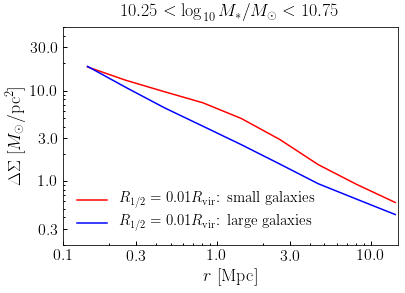

In [141]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()

__=ax.plot(rp_mids, ds_small2, color='red', 
           label=r'$R_{1/2}=0.01R_{\rm vir}$: ${\rm small\ galaxies}$')
__=ax.plot(rp_mids, ds_large2, color='blue', 
           label=r'$R_{1/2}=0.01R_{\rm vir}$: ${\rm large\ galaxies}$')

legend = ax.legend()

ax.set_xticks((0.1, 0.3, 1, 3, 10))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_yticks((0.3, 1, 3, 10, 30))
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
xlim = ax.set_xlim(0.1, 15)
ylim = ax.set_ylim(0.2, 50)

ylabel = ax.set_ylabel(r'$\Delta\Sigma$  $[M_{\odot}/{\rm pc^2}]$')
xlabel = ax.set_xlabel(r'$r$  $[{\rm Mpc}]$')
title = ax.set_title(r'$10.25 < \log_{10}M_{\ast}/M_{\odot} < 10.75$')

# figname = 'rvir_only_lensing_prediction2.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

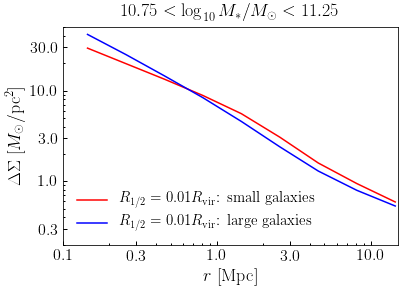

In [142]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()

__=ax.plot(rp_mids, ds_small3, color='red', 
           label=r'$R_{1/2}=0.01R_{\rm vir}$: ${\rm small\ galaxies}$')
__=ax.plot(rp_mids, ds_large3, color='blue', 
           label=r'$R_{1/2}=0.01R_{\rm vir}$: ${\rm large\ galaxies}$')

legend = ax.legend()

ax.set_xticks((0.1, 0.3, 1, 3, 10))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_yticks((0.3, 1, 3, 10, 30))
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
xlim = ax.set_xlim(0.1, 15)
ylim = ax.set_ylim(0.2, 50)

ylabel = ax.set_ylabel(r'$\Delta\Sigma$  $[M_{\odot}/{\rm pc^2}]$')
xlabel = ax.set_xlabel(r'$r$  $[{\rm Mpc}]$')
title = ax.set_title(r'$10.75 < \log_{10}M_{\ast}/M_{\odot} < 11.25$')

# figname = 'rvir_only_lensing_prediction3.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

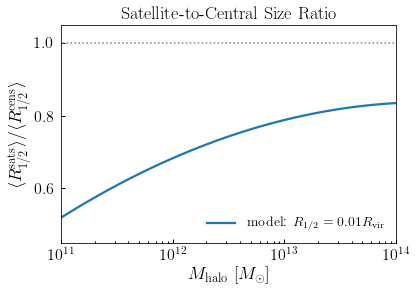

In [143]:
log_mpeak_bins = np.linspace(11., 14.25, 35)
satmask = mock['upid'] != -1
cenmask = ~satmask & (mock['first_acc_scale']>1)
from scipy.stats import binned_statistic

median_size_sats, __, __ = binned_statistic(
    np.log10(mock['mpeak'][satmask]), mock['r50_nocorr'][satmask], 
                                   bins=log_mpeak_bins)
median_size_cens, __, __ = binned_statistic(
    np.log10(mock['mpeak'][cenmask]), mock['r50_nocorr'][cenmask], 
                                   bins=log_mpeak_bins)
log_mpeak_mids = 0.5*(log_mpeak_bins[:-1] + log_mpeak_bins[1:])

size_ratio = median_size_sats/median_size_cens

from scipy.signal import savgol_filter
from scipy.signal import medfilt
smoothed_size_ratio = medfilt(size_ratio, 5)
smoothed_size_ratio = savgol_filter(smoothed_size_ratio, 5, 3)
p = np.polyfit(log_mpeak_mids, smoothed_size_ratio, 2)
a2, a1, a0 = p

fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

x = np.linspace(11, 15, 100)
y = a0 + a1*x + a2*x**2
__=ax.plot(10**x, y, label=r'${\rm model}$: $R_{1/2}=0.01R_{\rm vir}$', lw=2.25)

__=ax.plot(np.logspace(10, 15, 100), np.ones(100), ':', color='gray')
ylim = ax.set_ylim(0.45, 1.05)
xlim = ax.set_xlim(1e11, 1e14)
xlabel = ax.set_xlabel(r'$M_{\rm halo}$ $[M_{\odot}]$')
ylabel = ax.set_ylabel(r'$\langle R^{\rm sats}_{1/2}\rangle/\langle R^{\rm cens}_{1/2}\rangle$')
title = ax.set_title(r'${\rm Satellite}$-${\rm to}$-${\rm Central\ Size\ Ratio}$')
legend = ax.legend(fontsize=14)
ax.tick_params(pad=7)
# figname = 'cen_sat_size_ratios.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [144]:
small1 = mock[small_sm_mask]
large1 = mock[large_sm_mask]
small2 = mock[small_sm_mask2]
large2 = mock[large_sm_mask2]
small3 = mock[small_sm_mask3]
large3 = mock[large_sm_mask3]

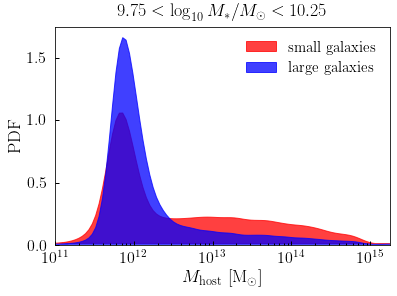

In [145]:

from scipy.stats import gaussian_kde
result_small1 = gaussian_kde(np.log10(small1['host_mvir']))
result_large1 = gaussian_kde(np.log10(large1['host_mvir']))

fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

m = np.linspace(11, 15.25, 100)
__=ax.fill(10**m, result_small1.pdf(m), color='red', alpha=0.75, 
           label=r'${\rm small\ galaxies}$')
__=ax.fill(10**m, result_large1.pdf(m), color='blue', alpha=0.75, 
           label=r'${\rm large\ galaxies}$')
xlim = ax.set_xlim(10**11, 10**15.25)
ylim = ax.set_ylim(ymin=0)
ax.tick_params(pad=8)
xlabel = ax.set_xlabel(r'$M_{\rm host}$ $[{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')
legend = ax.legend()
title = ax.set_title(r'$9.75 < \log_{10}M_{\ast}/M_{\odot} < 10.25$')
# figname = 'host_mass_distributions_sm9p75_sm10p25.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


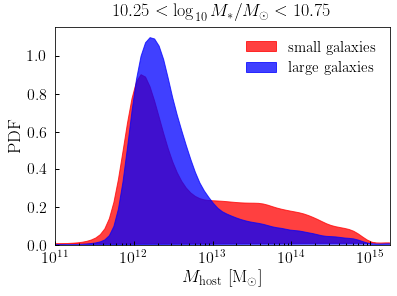

In [146]:
from scipy.stats import gaussian_kde
result_small2 = gaussian_kde(np.log10(small2['host_mvir']))
result_large2 = gaussian_kde(np.log10(large2['host_mvir']))

fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

m = np.linspace(11, 15.25, 75)
__=ax.fill(10**m, result_small2.pdf(m), color='red', alpha=0.75, 
           label=r'${\rm small\ galaxies}$')
__=ax.fill(10**m, result_large2.pdf(m), color='blue', alpha=0.75, 
           label=r'${\rm large\ galaxies}$')
xlim = ax.set_xlim(10**11, 10**15.25)
ylim = ax.set_ylim(ymin=0)
ax.tick_params(pad=8)
xlabel = ax.set_xlabel(r'$M_{\rm host}$ $[{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')
legend = ax.legend()
title = ax.set_title(r'$10.25 < \log_{10}M_{\ast}/M_{\odot} < 10.75$')
# figname = 'host_mass_distributions_sm10p25_sm10p75.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


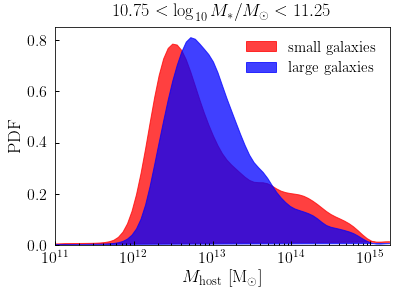

In [147]:
from scipy.stats import gaussian_kde
result_small3 = gaussian_kde(np.log10(small3['host_mvir']))
result_large3 = gaussian_kde(np.log10(large3['host_mvir']))

fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

m = np.linspace(11, 15.25, 75)
__=ax.fill(10**m, result_small3.pdf(m), color='red', alpha=0.75, 
           label=r'${\rm small\ galaxies}$')
__=ax.fill(10**m, result_large3.pdf(m), color='blue', alpha=0.75, 
           label=r'${\rm large\ galaxies}$')
xlim = ax.set_xlim(10**11, 10**15.25)
ylim = ax.set_ylim(ymin=0)
ax.tick_params(pad=8)
xlabel = ax.set_xlabel(r'$M_{\rm host}$ $[{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')
legend = ax.legend()
title = ax.set_title(r'$10.75 < \log_{10}M_{\ast}/M_{\odot} < 11.25$')
# figname = 'host_mass_distributions_sm10p75_sm11p25.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


### Check some correlations for the referee

In [148]:
print(mock.keys())

['upid', 'mpeak', 'rvir', 'mvir', 'vx', 'vy', 'vz', 'uparent_dist', 'vmax', 'desc_id', 'halo_id', 'vmax_at_mpeak', 'y', 'x', 'z', 'dvmax_rank', 'orphan', 'last_snap', 'last_snap_halo_id', 'has_halotools_match', 'mpeak_scale', 'acc_scale', 'first_acc_scale', 'halfmass_scale', 'has_orphan_hlist_match', 'sm', 'vmax_at_mpeak_percentile', 'noisy_vmax_at_mpeak_percentile', 'orphan_mass_loss_percentile', 'orphan_vmax_at_mpeak_percentile', 'orphan_vmax_loss_percentile', 'orphan_fixed_mpeak_mhost_percentile', 'zpeak', 'zpeak_no_splashback', 'rvir_zpeak', 'rvir_zpeak_no_splashback', 'hostid', 'host_mvir', 'frac_mpeak_remaining', 'frac_vpeak_remaining', 'r50_nocorr', 'r50_maxcorr', 'r50_midcorr', 'r50_nospl', 'median_r50', 'r50_mstar', 'frac_surviving_dm', 'frac_surviving_mstar', 'frac_stripped_r50', 'r50_mstar_stripping', 'r50', 'r50_median']


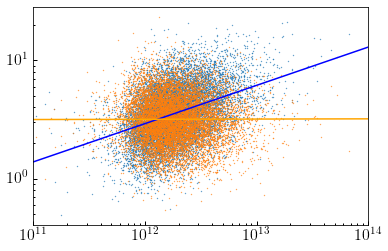

In [149]:
sample_mask = mock['sm'] > 10.45
sample_mask *= mock['sm'] < 10.55
cenmask = mock['upid'] == -1
sample = mock[sample_mask]
sample_cens = mock[sample_mask & cenmask]

c1_nocorr, c0_nocorr = np.polyfit(
    np.log10(sample_cens['mvir']), np.log10(sample_cens['r50_nocorr']), deg=1)
c1_mstar_stripping, c0_mstar_stripping = np.polyfit(
    np.log10(sample_cens['mvir']), np.log10(sample_cens['r50_mstar_stripping']), deg=1)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.scatter(sample_cens['mvir'], sample_cens['r50_nocorr'], s=0.1)
__=ax.scatter(sample_cens['mvir'], sample_cens['r50_mstar_stripping'], s=0.1)

logmarr = np.linspace(11, 14, 100)
__=ax.plot(10**logmarr, 10**(c0_nocorr + c1_nocorr*logmarr), color='blue')
__=ax.plot(10**logmarr, 10**(c0_mstar_stripping + c1_mstar_stripping*logmarr), color='orange')
xlim = ax.set_xlim(1e11, 1e14)

In [150]:
print(sample_cens.keys())

['upid', 'mpeak', 'rvir', 'mvir', 'vx', 'vy', 'vz', 'uparent_dist', 'vmax', 'desc_id', 'halo_id', 'vmax_at_mpeak', 'y', 'x', 'z', 'dvmax_rank', 'orphan', 'last_snap', 'last_snap_halo_id', 'has_halotools_match', 'mpeak_scale', 'acc_scale', 'first_acc_scale', 'halfmass_scale', 'has_orphan_hlist_match', 'sm', 'vmax_at_mpeak_percentile', 'noisy_vmax_at_mpeak_percentile', 'orphan_mass_loss_percentile', 'orphan_vmax_at_mpeak_percentile', 'orphan_vmax_loss_percentile', 'orphan_fixed_mpeak_mhost_percentile', 'zpeak', 'zpeak_no_splashback', 'rvir_zpeak', 'rvir_zpeak_no_splashback', 'hostid', 'host_mvir', 'frac_mpeak_remaining', 'frac_vpeak_remaining', 'r50_nocorr', 'r50_maxcorr', 'r50_midcorr', 'r50_nospl', 'median_r50', 'r50_mstar', 'frac_surviving_dm', 'frac_surviving_mstar', 'frac_stripped_r50', 'r50_mstar_stripping', 'r50', 'r50_median']


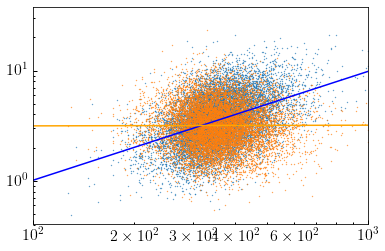

In [151]:
sample_mask = mock['sm'] > 10.45
sample_mask *= mock['sm'] < 10.55
cenmask = mock['upid'] == -1
sample = mock[sample_mask]
sample_cens = mock[sample_mask & cenmask]

c1_nocorr, c0_nocorr = np.polyfit(
    np.log10(sample_cens['rvir_zpeak']), np.log10(sample_cens['r50_nocorr']), deg=1)
c1_mstar_stripping, c0_mstar_stripping = np.polyfit(
    np.log10(sample_cens['rvir_zpeak']), np.log10(sample_cens['r50_mstar_stripping']), deg=1)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.scatter(sample_cens['rvir_zpeak'], sample_cens['r50_nocorr'], s=0.1)
__=ax.scatter(sample_cens['rvir_zpeak'], sample_cens['r50_mstar_stripping'], s=0.1)

_lgr = np.linspace(2, 3.5, 100)
__=ax.plot(10**_lgr, 10**(c0_nocorr + c1_nocorr*_lgr), color='blue')
__=ax.plot(10**_lgr, 10**(c0_mstar_stripping + c1_mstar_stripping*_lgr), color='orange')
xlim = ax.set_xlim(100, 1000)

In [152]:
mock['sm_post_stripping'] = np.log10(
    mock['frac_surviving_mstar']*(10**mock['sm']))

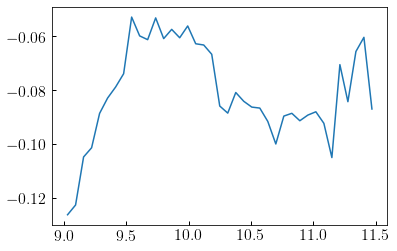

In [153]:
logsm_bins = np.linspace(9, 11.5, 40)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

smf_counts, __ = np.histogram(mock['sm'], bins=logsm_bins, density=False)
smf_counts2, __ = np.histogram(mock['sm_post_stripping'], bins=logsm_bins, density=False)

fig, ax = plt.subplots(1, 1)

# yscale = ax.set_yscale('log')
# __=ax.plot(logsm_mids, smf_counts)
# __=ax.plot(logsm_mids, smf_counts2)

fracdiff = (smf_counts2 - smf_counts)/smf_counts.astype('f4')
__=ax.plot(logsm_mids, fracdiff)
